In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from diffusers import DiffusionPipeline
import numpy as np
import random
import torch
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
from typing import Optional, Tuple, Union
import pandas as pd

from fid.fid_score import calculate_activation_statistics, save_statistics, load_statistics, calculate_frechet_distance, get_activations
from fid.inception import InceptionV3

from PIL import Image
from tqdm.auto import tqdm
from torch import autocast

from src.visualise import image_grid, latent_to_img, decode_latent, output_to_img
from schedulers.euler_discrete import EulerDiscreteCustomScheduler, FrozenDict, randn_tensor
from src.score_utils import get_sigmas, get_score_input, scale_input, get_score, step_score
from src.denoise_utils import denoise
from src.sampling_utils import random_step, langevin_step, repulsive_step_parallel
from src.kernel import RBF
from src.embedding import CNN64, CNN16, init_weights, AverageDim, Average, VAEAverage, Style, VGG, VGG_dropout, VGG_noise
from src.datasets import StyleDataset, ArtistDataset
from src.train import train
from src.metric_utils import fid_metric

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from collections import deque
from torch.utils.data import DataLoader, Dataset, random_split
from glob import glob

**FID**
- Comparison of max diversity and query set of samples
- Get distribution of FID vectors for each set + fit gaussian
- Frechet distance between gaussians

In [3]:
exps = ['max_div2','min_div','vgg_noise_all_r1000','cnn16_all_r1000','averagedim_all_r1000','ro3_all_r1000']
stats = {}
local = {}
gram64 = {}
for exp in exps:
    print(exp)
    metrics = fid_metric(exp,subject='cave',artistnum=-2)
    stats[exp] = metrics['stats']
    local[exp] = metrics['local']
    gram64[exp] = metrics['gram64']


max_div2
min_div
vgg_noise_all_r1000
cnn16_all_r1000
Starting to sample.
Starting to sample.
Starting to sample.
averagedim_all_r1000
Starting to sample.
Starting to sample.
Starting to sample.
ro3_all_r1000
Starting to sample.
Starting to sample.
Starting to sample.


In [2]:
exps = ['max_div2','min_div','averagedim_all_r1000','cnn16_all_r1000','langevin','ro3_all_r1000','vgg_noise_all_r1000','vgg_noisero3_all_r1000']
stats = {}
local = {}
gram64 = {}
for exp in exps:
    print(exp)
    metrics = fid_metric(exp,subject='cave',artistnum=0)
    stats[exp] = metrics['stats']
    local[exp] = metrics['local']
    gram64[exp] = metrics['gram64']

max_div2
min_div
averagedim_all_r1000
cnn16_all_r1000


/data/ap2619/particlediffusion/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/ap2619/particlediffusion/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting to sample.
Starting to sample.
Starting to sample.
langevin
Starting to sample.
Starting to sample.
Starting to sample.
ro3_all_r1000
Starting to sample.
Starting to sample.
Starting to sample.
vgg_noise_all_r1000
Starting to sample.
Starting to sample.
Starting to sample.
vgg_noisero3_all_r1000
Starting to sample.
Starting to sample.
Starting to sample.


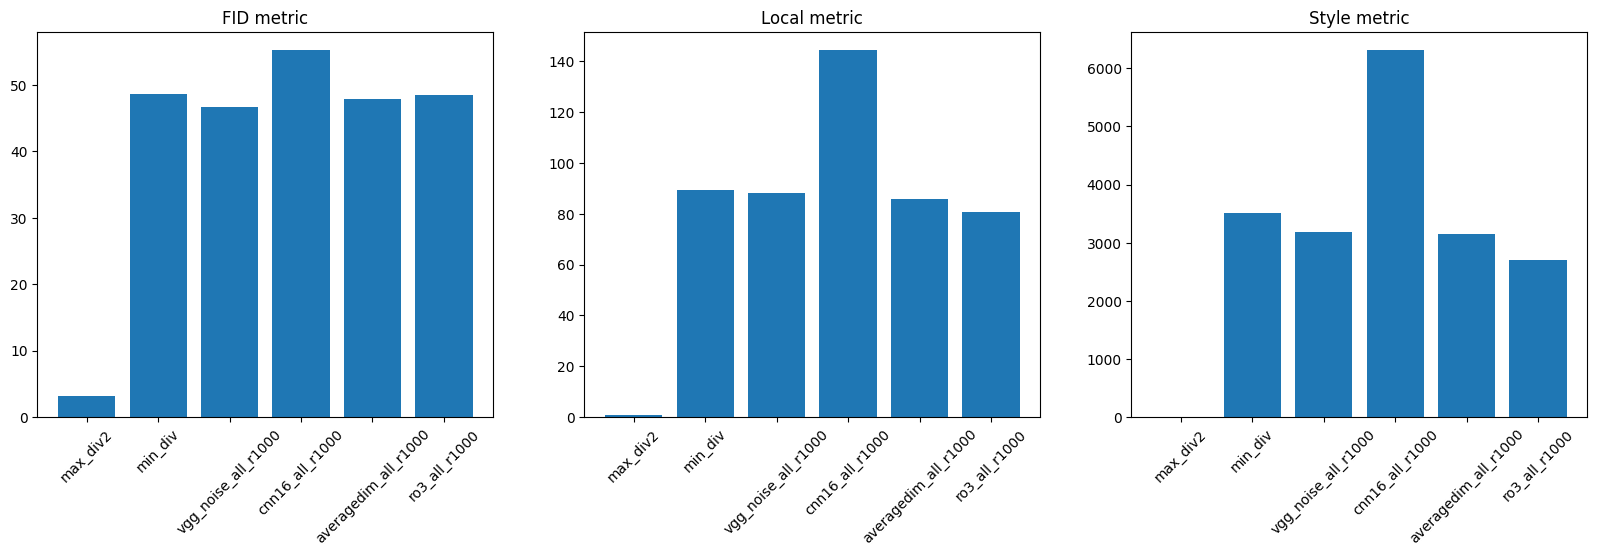

In [4]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
data = stats
names = list(data.keys())
values = list(data.values())
plt.bar(range(len(data)), values, tick_label=names)
plt.xticks(rotation=45)
plt.title('FID metric')
plt.subplot(1,3,2)
data = local
names = list(data.keys())
values = list(data.values())
plt.bar(range(len(data)), values, tick_label=names)
plt.xticks(rotation=45)
plt.title('Local metric')
plt.subplot(1,3,3)
data = gram64
names = list(data.keys())
values = list(data.values())
plt.bar(range(len(data)), values, tick_label=names)
plt.xticks(rotation=45)
plt.title('Style metric')
plt.show()

In [20]:
gram64

{'max_div2': 0.6090713574376423,
 'min_div': 829.1604794955174,
 'langevin': 7547.482865413876,
 'vgg_noise_all_r1000': 1232.1881377118361,
 'averagedim_all_r1000': 832.3566112460071,
 'ro3_all_r1000': 1476.7568334539387}

In [3]:
for exp_file in glob('data/final/cave/*/'):
    exp = os.path.basename(os.path.dirname(exp_file))
    if exp!='max_div':
        print(exp)
        print(fid_metric(exp))

max_div2
{'stats': 3.1619584465502157, 'local': 0.8060364672148523, 'gram64': 0.6090713574376423}
min_div
{'stats': 71.37755367342379, 'local': 8.685041981553198, 'gram64': 856.9077024221001}
averagedim_all_r10
{'stats': 71.02356331322824, 'local': 8.456937079276585, 'gram64': 814.0823104446572}
vggro3_all_r1000
{'stats': 68.17141354830105, 'local': 8.22528265592807, 'gram64': 859.7519633016946}
averagedim_all_r100
{'stats': 71.06855635677621, 'local': 8.59384055091813, 'gram64': 849.0034720353087}
ro3_all_r500
{'stats': 65.50791897882073, 'local': 7.894506363638868, 'gram64': 882.1449313092112}
cnn16_all_r500
{'stats': 71.79875445650177, 'local': 8.764678782291028, 'gram64': 798.5773165609694}
vgg_all_r1000
Starting to sample.
Starting to sample.
Starting to sample.
{'stats': 65.97050385508012, 'local': 7.7618890958351585, 'gram64': 745.340456734702}
vgg_dc_channel_all_r1000
Starting to sample.
Starting to sample.
Starting to sample.
{'stats': 64.42709019429765, 'local': 7.99611041147

In [7]:
# Read image sets
exp='max_div'
# f = []
# for file in glob(f"data/final/cave/{exp}/*/*.png"):
#     f.append(file)
f = []
for file in glob(f"data/final/cave/min_div/Thomas_Kinkade/*.png"):
    f.append(file)
for file in glob(f"data/final/cave/ro3_all_r1000/Thomas_Kinkade/*.png"):
    f.append(file)
for file in glob(f"data/final/cave/vgg_noise_all_r1000/Thomas_Kinkade/*.png"):
    f.append(file)

In [18]:
fid_dir = "fid" #/pt_inception-2015-12-05-6726825d.pth"
dims = 2048  # 64, 192, 768, 2048
device = 'cuda'
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
model = InceptionV3([block_idx], model_dir=fid_dir).to(device)
# m, s = calculate_activation_statistics(f, model, 50, dims, device)

act = get_activations(f, model, 50, dims, device, None)

# save_statistics(f"data/final/cave/{exp}_stats.npz",m,s)

/data/ap2619/particlediffusion/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/ap2619/particlediffusion/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting to sample.


In [19]:
# t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(act)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.011s...
[t-SNE] Computed neighbors for 10000 samples in 1.447s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.610976
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.726639
[t-SNE] KL divergence after 1000 iterations: 3.153918


/tmp/ipykernel_2513262/2593921330.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')


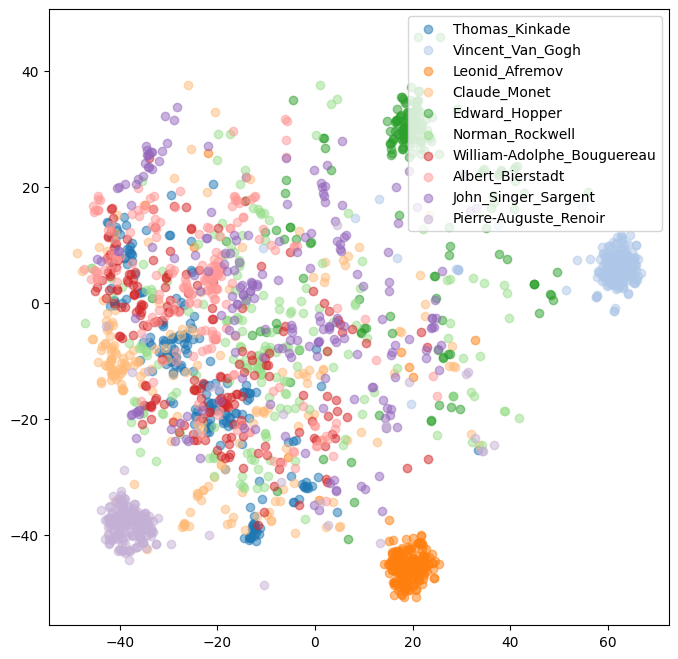

In [20]:
# Plotfor artists (max_div)
artists = []
for file in glob(f"data/final/cave/max_div/*/"):
    artist = os.path.basename(os.path.dirname(file))
    artists.append(artist)

# Plot those points as a scatter plot and label them based on the pred labels
from matplotlib import cm
num_categories = 10
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))

for i, artist in enumerate(artists):
    if i in range(0,0+num_categories):
        indices = np.zeros(len(tsne_proj))
        indices[i*200:(i+1)*200] = 1
        indices = indices==1
        ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(i)).reshape(1,4), label = artist ,alpha=0.5)
ax.legend()#fontsize='large', markerscale=2)
plt.show()

/tmp/ipykernel_2393904/3239418678.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')


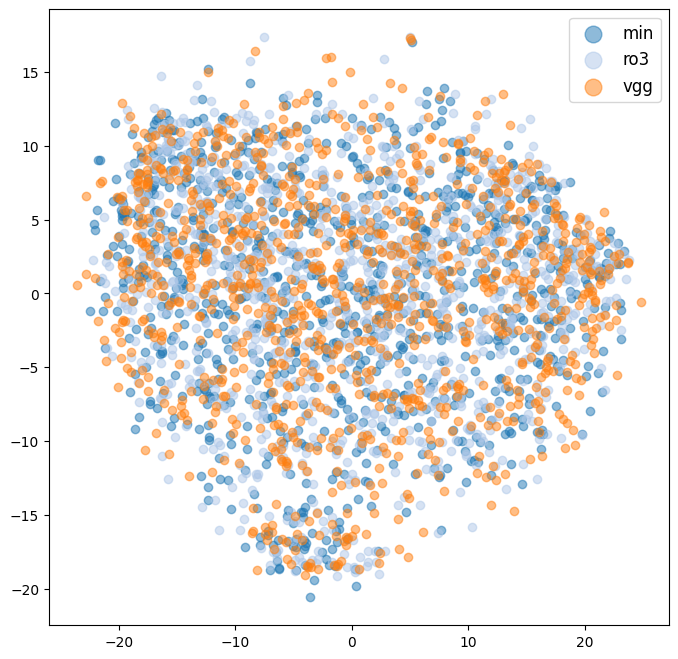

In [11]:
# Plot just one artist and different methods
from matplotlib import cm
# Plot those points as a scatter plot and label them based on the pred labels
# plt.figure(figsize=(20,20))
cats = ['min','ro3','vgg']
# cats=['vgg']
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 10
for i, cat in enumerate(cats):
    indices = np.zeros(len(tsne_proj))
    indices[i*1000:(i+1)*1000] = 1
    indices = indices==1
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(i)).reshape(1,4), label = cat ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

In [43]:
m0, s0 = load_statistics("data/final/cave/max_div_stats.npz")
m, s = load_statistics(f"data/final/cave/{exp}_stats.npz")
fid = calculate_frechet_distance(m0, s0, m, s)
fid

65.50791897882073

Localisation diversity

In [15]:
## activations
fid_dir = "fid" #/pt_inception-2015-12-05-6726825d.pth"
dims = 192  # 64, 192, 768, 2048
device = 'cuda'
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
model = InceptionV3([block_idx], model_dir=fid_dir).to(device)
# m, s = calculate_activation_statistics(f, model, 50, dims, device)

act = get_activations(f, model, 50, dims, device, None)
# act = np.mean(act,axis=1)
# act = act.reshape(act.shape[0], -1)
# mu = np.mean(act, axis=0)
# sigma = np.cov(act, rowvar=False)
# save_statistics(f'data/final/cave/{exp}_local.npz',mu,sigma)


Starting to sample.


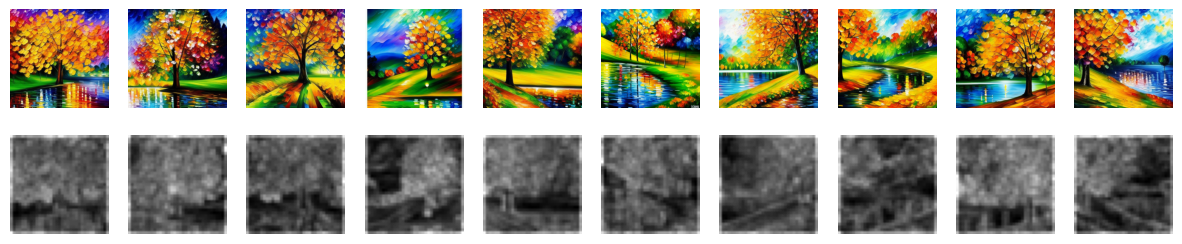

In [16]:
mean_act = np.mean(act,axis=1)
n=10
plt.figure(figsize=(15,3))
for i in range(n):
    img = Image.open(f[50+i])
    plt.subplot(2,n,i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(2,n,n + i + 1)
    plt.imshow(mean_act[50+i], cmap='gray')
    plt.axis('off')
# plt.savefig("figures/inceptionfeatures.pdf")

In [46]:
# Get FID of each artist's images
for f in glob("data/styles/artists/*"):
    imgs = []
    for imgf in glob(f"{f}/*.png"):
        imgs.append(imgf)
    print(len(imgs))
    m, s = calculate_activation_statistics(imgs, model, 8, dims, device)
    save_statistics(f"{f}/fid.npz",m,s)

In [47]:
m0, s0 = load_statistics("data/final/cave/max_div_local.npz")
m, s = load_statistics(f"data/final/cave/{exp}_local.npz")
fid = calculate_frechet_distance(m0, s0, m, s)
fid

7.894506363638868

Style diversity


In [21]:
f = ['data/final/cave/max_div/Erin_Hanson/artist18_0.png','data/final/cave/max_div/Erin_Hanson/artist18_1.png','data/final/cave/max_div/Alfred_Eisenstaedt/artist46_0.png','data/final/cave/max_div/Alfred_Eisenstaedt/artist46_1.png']

In [5]:
exp='max_div'
f = []
for file in glob(f"data/final/cave/{exp}/*/*.png"):
    f.append(file)

In [22]:
## activations
fid_dir = "fid" #/pt_inception-2015-12-05-6726825d.pth"
dims = 64  # 64, 192, 768, 2048
device = 'cuda'
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
model = InceptionV3([block_idx], model_dir=fid_dir).to(device)
# m, s = calculate_activation_statistics(f, model, 50, dims, device)

act = get_activations(f, model, 50, dims, device, None, gap=True)
gram = np.einsum('ni,nj->nij',act,act)
# Flattened upper triangular 
sims = []
for i in range(len(gram)):
    sim = gram[i][np.triu_indices(dims)]
    sims.append(sim)
sims = np.stack(sims)
# mu = np.mean(sims, axis=0)
# sigma = np.cov(sims, rowvar=False)
# save_statistics(f'data/final/cave/{exp}_gram64.npz',mu,sigma)

/data/ap2619/particlediffusion/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/ap2619/particlediffusion/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting to sample.


In [34]:
for i in range(4):
    for j in range(i,4):
        print(i,j)
        print(np.linalg.norm(sims[i] -sims[j]))

0 0
0.0
0 1
63.29105
0 2
101.768135
0 3
75.241585
1 1
0.0
1 2
112.38664
1 3
85.00169
2 2
0.0
2 3
40.360176
3 3
0.0


In [49]:
m0, s0 = load_statistics("data/final/cave/max_div_gram64.npz")
m, s = load_statistics(f"data/final/cave/{exp}_gram64.npz")
fid = calculate_frechet_distance(m0, s0, m, s)
fid

882.1449313092112

In [50]:
# Plot images from dataset
import glob
n=2
images = []
for folder in glob.glob("data/fruit/*"):
    i=0
    for file in glob.glob(os.path.join(folder,"*")):
        if i<n:
            images.append(Image.open(file))
            i+=1

grid = image_grid(images, rows=n, cols=10)



Checking metrics work

In [ ]:
# Find good examples where style is same but location changes

# Compare features of images with different styles